Epoch 1/200, Training Loss: 0.019650, Validation Loss: 0.201220
Epoch 2/200, Training Loss: 0.016596, Validation Loss: 0.165580
Epoch 3/200, Training Loss: 0.013842, Validation Loss: 0.131799
Epoch 4/200, Training Loss: 0.010963, Validation Loss: 0.099764
Epoch 5/200, Training Loss: 0.008515, Validation Loss: 0.069661
Epoch 6/200, Training Loss: 0.005943, Validation Loss: 0.042482
Epoch 7/200, Training Loss: 0.004141, Validation Loss: 0.020081
Epoch 8/200, Training Loss: 0.002295, Validation Loss: 0.005143
Epoch 9/200, Training Loss: 0.001517, Validation Loss: 0.000004
Epoch 10/200, Training Loss: 0.001494, Validation Loss: 0.002859
Epoch 11/200, Training Loss: 0.001786, Validation Loss: 0.006260
Epoch 12/200, Training Loss: 0.002107, Validation Loss: 0.005265
Epoch 13/200, Training Loss: 0.001925, Validation Loss: 0.002117
Epoch 14/200, Training Loss: 0.001729, Validation Loss: 0.000227
Epoch 15/200, Training Loss: 0.001607, Validation Loss: 0.000110
Epoch 16/200, Training Loss: 0.001

c:\Users\HP VICTUS\anaconda3\envs\quant\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


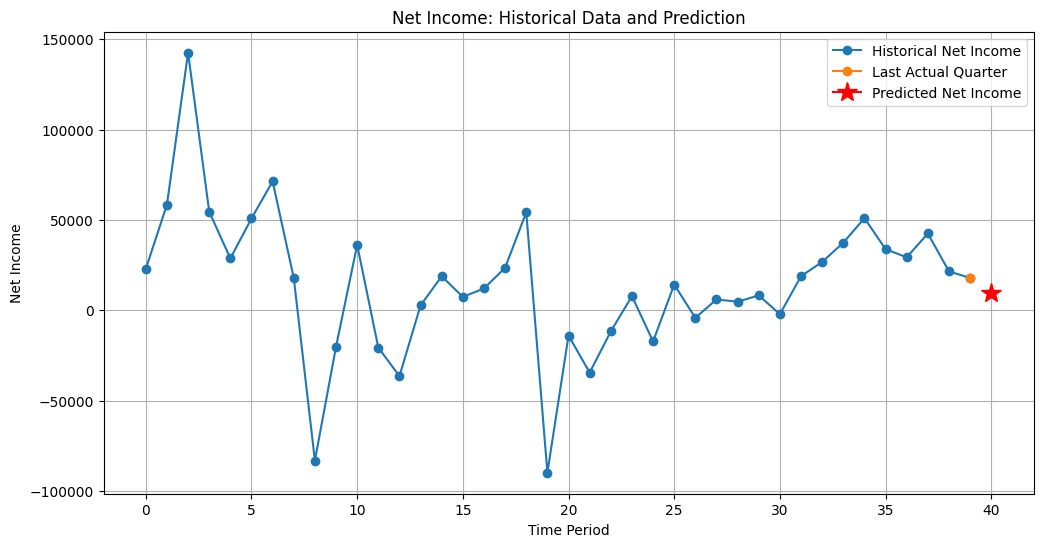

In [14]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Model Definitions
class LSTMNet(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, output_size=1):
        super(LSTMNet, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(-1)
        lstm_out, _ = self.lstm(x)
        predictions = self.fc(lstm_out[:, -1])
        return predictions

# Data Preparation Functions
def prepare_sequences(data, sequence_length=4):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:(i + sequence_length)])
        targets.append(data[i + sequence_length])
    return np.array(sequences), np.array(targets)

def evaluate_model(true_values, predicted_values):
    # Ensure inputs are NumPy arrays
    true_values = np.array(true_values)
    predicted_values = np.array(predicted_values)
    
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    r2 = r2_score(true_values, predicted_values)
    
    print(f"Evaluation Metrics:\n"
          f"MAE: {mae:.2f}\n"
          f"RMSE: {rmse:.2f}\n"
          f"MAPE: {mape:.2f}%\n"
          f"R^2: {r2:.2f}\n")
    
    return mae, rmse, mape, r2


# Training Function with Early Stopping
def train_with_early_stopping(model, X_train, y_train, X_val, y_val, epochs=200, batch_size=16, patience=10):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Validation Loss
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = loss_function(val_pred, y_val).item()
        
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {total_loss/len(X_train):.6f}, Validation Loss: {val_loss:.6f}")
        
        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

# Prediction and Visualization Functions
def predict(model, data, scaler, sequence_length=4):
    last_sequence = data[-sequence_length:]
    last_sequence = torch.FloatTensor(last_sequence).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        prediction_scaled = model(last_sequence).numpy()
    prediction = scaler.inverse_transform(prediction_scaled)
    return prediction[0][0]

def plot_predictions(df, predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(df)), df['Net Income'], label='Historical Net Income', marker='o')
    plt.plot(len(df)-1, df['Net Income'].iloc[-1], marker='o', label='Last Actual Quarter')
    plt.plot(len(df), predictions, marker='*', color='red', label='Predicted Net Income', markersize=15)
    plt.title('Net Income: Historical Data and Prediction')
    plt.xlabel('Time Period')
    plt.ylabel('Net Income')
    plt.legend()
    plt.grid()
    plt.show()

# Load Data
df = pd.read_excel('quarterly_data.xlsx')
features = df[['Revenue', 'Cost of Revenue', 'Gross Profit', 'Depreciation/Amortization', 'Total Operating Expense', 'Operating Income', 'Net Income', 'Normalized EBITDA', 'GDP growth rate']]
features.columns = ['Revenue', 'Cost of Revenue', 'Gross Profit', 'Depreciation/Amortization', 'Total Operating Expense', 'Operating Income', 'Net Income', 'Normalized EBITDA', 'GDP growth rate']
features = features.iloc[::-1].reset_index(drop=True)

# Preprocessing
net_income = features['Net Income'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(net_income)

sequence_length = 4
X, y = prepare_sequences(scaled_data, sequence_length)
X_train, y_train = torch.FloatTensor(X[:-1]), torch.FloatTensor(y[:-1])
X_val, y_val = torch.FloatTensor(X[-1:]), torch.FloatTensor(y[-1:])

# Train and Predict
model = LSTMNet()
train_with_early_stopping(model, X_train, y_train, X_val, y_val, epochs=200, patience=10)

predicted_value = predict(model, scaled_data, scaler, sequence_length)
ensemble_results = pd.DataFrame({
    'Period': ['Last Quarter', 'Predicted Next Quarter'],
    'Net Income': [
        net_income[-1][0],
        predicted_value
    ],
    'Quarter-over-Quarter Change %': [
        np.nan,
        ((predicted_value - net_income[-1][0]) / net_income[-1][0]) * 100
    ]
})

# Evaluate and Plot
print("\nEnsemble Prediction Results:")
print(ensemble_results.round(2))

evaluate_model([net_income[-1][0]], [predicted_value])
plot_predictions(features, predicted_value)
